In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

from ast import literal_eval

import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text

from sklearn.metrics import confusion_matrix, recall_score, precision_score

set_style("whitegrid")

In [2]:
questions = pd.read_csv("archive/questions_cleaned.csv", nrows=200000, 
                        converters={'cleaned_body': literal_eval})

## Report number of closed and open questions in the dataset

In [3]:
count = 0
for i in range(0,np.shape(questions)[0]):
    if pd.isna(questions.iloc[i].ClosedDate):
        count = count+1
        
print("Number of closed questions:", count)
print("Number of open questions:", np.shape(questions)[0] - count)

Number of closed questions: 193581
Number of open questions: 6419


Let's define a new column of 0s and 1s that indicates if the question is still open (0) or if it has been closed (1).

In [4]:
questions['Closed'] = 1

for i in range(0,np.shape(questions)[0]):
    if pd.isna(questions.iloc[i].ClosedDate):
        questions['Closed'].iloc[i] = 0

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
def clean_text(text):

    for i in range(0,len(text)):
        # remove the random non-ascii characters
        text[i] = text[i].encode("ascii", "ignore").decode()
        
        # remove numbers
        text[i] = re.sub(r'[0-9]+', '', text[i])
        
        # remove anything that isn't a word or whitespace
        text[i] = re.sub(r'[^\w\s]', '', text[i])    
        
        # remove short words with 1 to 3 characters
        shortword = re.compile(r'\W*\b\w{1,3}\b')
        text[i] = shortword.sub('', text[i])
        
        
    # some of the above re calls replaced things with empty strings, so now let's remove those    
    while("" in text) :
        text.remove("")    
        
    return text

In [6]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C, max_iter=1000).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

## Construct individual datasets for closed and open questions

In [7]:
open_questions = questions[pd.isna(questions['ClosedDate'])].copy()
np.shape(open_questions)[0]

193581

In [8]:
closed_questions = questions[pd.notna(questions['ClosedDate'])].copy()
np.shape(closed_questions)[0]

6419

'ratios' will be the ratio of open-to-closed questions -- a ratio of 0.05 means 5% open and 95% closed, 0.25 means 25% are open and 75% are closed, etc.

In [32]:
num_ratios = 19
tot_questions = 5000

ratios = np.linspace(0.05,0.95,num_ratios)

accs = []
TNs = []
FPs = []
FNs = []
TPs = []

In [31]:
print(ratios)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


In [33]:
for i in range(0,len(ratios)):
    num_open = int(ratios[i]*tot_questions)
    num_closed = int((1.0-ratios[i])*tot_questions)
    partial_set = pd.concat([open_questions[0:num_open], closed_questions[0:num_closed]])
    dataset = partial_set
    dataset['cleaned_body'] = list(map(clean_text, dataset.cleaned_body))

    training_data, test_data = sklearn.model_selection.train_test_split(dataset.copy(), shuffle=True, 
                                                                    test_size = 0.3, random_state=961,
                                                                    stratify = dataset.Closed)

    bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False) 

    X_tr_bow = bow_transform.fit_transform(training_data['cleaned_body'])
    X_te_bow = bow_transform.transform(test_data['cleaned_body'])

    y_tr = training_data['Closed']
    y_te = test_data['Closed']

    model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
    accuracy = model_bow.score(X_te_bow, y_te)

    y_bow_test_pred = model_bow.predict(X_te_bow)

    confusion_matrix(y_te, y_bow_test_pred)
    TN = confusion_matrix(y_te, y_bow_test_pred)[0,0]
    FP = confusion_matrix(y_te, y_bow_test_pred)[0,1]
    FN = confusion_matrix(y_te, y_bow_test_pred)[1,0]
    TP = confusion_matrix(y_te, y_bow_test_pred)[1,1]
    
    accs.append(accuracy)
    TNs.append(TN)
    FPs.append(FP)
    FNs.append(FN)
    TPs.append(TP)

Test Score with bow features 0.9406666666666667
Test Score with bow features 0.8846666666666667
Test Score with bow features 0.8253333333333334
Test Score with bow features 0.7846666666666666
Test Score with bow features 0.748
Test Score with bow features 0.7246666666666667
Test Score with bow features 0.6966666666666667
Test Score with bow features 0.7033333333333334
Test Score with bow features 0.6933333333333334
Test Score with bow features 0.684
Test Score with bow features 0.684
Test Score with bow features 0.686
Test Score with bow features 0.7053333333333334
Test Score with bow features 0.7313333333333333
Test Score with bow features 0.7746666666666666
Test Score with bow features 0.8013333333333333
Test Score with bow features 0.8353333333333334
Test Score with bow features 0.894
Test Score with bow features 0.9453333333333334


### Plot the accuracy as a function of dataset ratio

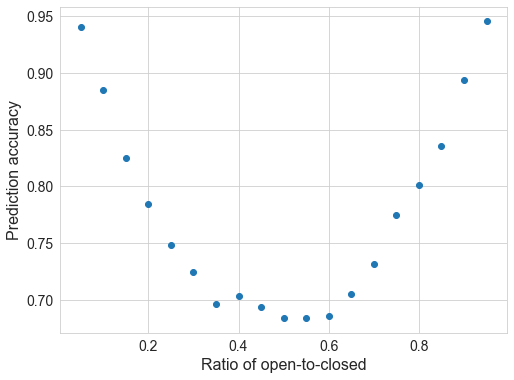

In [37]:
plt.figure(figsize=(8,6))

plt.scatter(ratios, accs)

plt.xlabel("Ratio of open-to-closed", fontsize=16)
plt.ylabel("Prediction accuracy", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

This plot looks conceptually as expected -- that is, parabolic. The more open questions there are in the dataset, the more likely the model will predict unseen questions as open and vice versa. Between ratios of 0.35 and 0.65, the accuracy hovers around 70%.

### Plot of confusion matrix elements

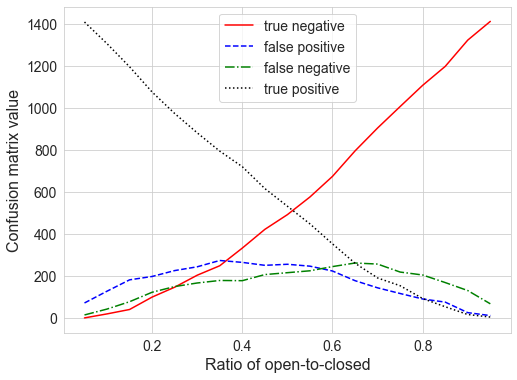

In [41]:
plt.figure(figsize=(8,6))

plt.plot(ratios, TNs, 'r-', label="true negative")
plt.plot(ratios, FPs, 'b--', label="false positive")
plt.plot(ratios, FNs, 'g-.', label="false negative")
plt.plot(ratios, TPs, 'k:', label="true positive")

plt.xlabel("Ratio of open-to-closed", fontsize=16)
plt.ylabel("Confusion matrix value", fontsize=16)
plt.legend(loc='upper center', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Our overall goal is to maximize true values (true negatives and true positives) while also minimizing false values (false positives and false negatives). There seems to be a baseline number of false values (~250 out of the 1,500 questions in the test set) *almost* regardless of the ratio in the dataset. In contrast, the value of true positives and true negatives vary linearly with respect to the underlying ratio in the training data. 